In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

from PIL import Image
import os
import re
import matplotlib.pyplot as plt

In [2]:
class HiraganaDataset(Dataset):
    def __init__(self, mode='train') -> None:
        super().__init__()
        lab2num = {}
        images = []
        labels = []
        for file in os.listdir('hiragana_images'):
            f = f'hiragana_images/{file}'
            img = Image.open(f)
            img = transforms.ToTensor()(img)
            images.append(img)

            f = f.split('/')[1]
            f = f[4:]
            label = re.split(r'\d+', f)[0]
            if not label in lab2num:
                lab2num[label] = len(lab2num)
            
            labels.append(lab2num[label])

        if mode == 'train':
            self.images = torch.stack(images)[::3]
            self.labels = labels[::3]

        if mode == 'valid':
            self.images = torch.stack(images)[1::3]
            self.labels = labels[1::3]

        if mode == 'test':
            self.images = torch.stack(images)[2::3]
            self.labels = labels[2::3]
        
        self.lab2num = lab2num
        self.num2lab = {v: k for k, v in self.lab2num.items()}

        if mode == 'train':
            self.transforms = transforms.RandomResizedCrop((32, 32), (0,75, 1.333))

        else:
            self.transforms = transforms.RandomResizedCrop((32, 32), (1, 1), (1, 1))

        self.hiragana = {
            "a":"あ","i":"い","u":"う","e":"え","o":"お",
            "ka":"か","ki":"き","ku":"く","ke":"け","ko":"こ",
            "ga":"が","gi":"ぎ","gu":"ぐ","ge":"げ","go":"ご",
            "sa":"さ","shi":"し","su":"す","se":"せ","so":"そ",
            "za":"ざ","ji":"じ","zu":"ず","ze":"ぜ","zo":"ぞ",
            "ta":"た","chi":"ち","tsu":"つ","te":"て","to":"と",
            "da":"だ","zu":"づ","de":"で","do":"ど",
            "na":"な","ni":"に","nu":"ぬ","ne":"ね","no":"の",
            "ha":"は","hi":"ひ","fu":"ふ","he":"へ","ho":"ほ",
            "ba":"ば","bi":"び","bu":"ぶ","be":"べ","bo":"ぼ",
            "pa":"ぱ","pi":"ぴ","pu":"ぷ","pe":"ぺ","po":"ぽ",
            "ma":"ま","mi":"み","mu":"む","me":"め","mo":"も",
            "ya":"や","yu":"ゆ","yo":"よ",
            "ra":"ら","ri":"り","ru":"る","re":"れ","ro":"ろ",
            "wa":"わ","wo":"を",
            "n":"ん",
            "kya":"きゃ","kyu":"きゅ","kyo":"きょ",
            "gya":"ぎゃ","gyu":"ぎゅ","gyo":"ぎょ",
            "sha":"しゃ","shu":"しゅ","sho":"しょ",
            "ja":"じゃ","ju":"じゅ","jo":"じょ",
            "cha":"ちゃ","chu":"ちゅ","cho":"ちょ",
            "nya":"にゃ","nyu":"にゅ","nyo":"にょ",
            "hya":"ひゃ","hyu":"ひゅ","hyo":"ひょ",
            "bya":"びゃ","byu":"びゅ","byo":"びょ",
            "pya":"ぴゃ","pyu":"ぴゅ","pyo":"ぴょ",
            "mya":"みゃ","myu":"みゅ","myo":"みょ",
            "rya":"りゃ","ryu":"りゅ","ryo":"りょ",
            "vu":"ゔ",
            "sakuon":"っ"
        }


    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img = self.images[index]
        img = self.transforms(img.unsqueeze(0))[0]
        return img, self.labels[index]

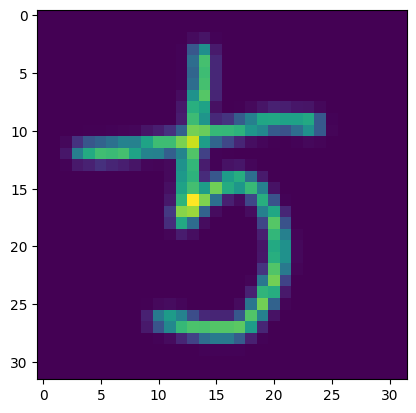

In [3]:
dataset = HiraganaDataset()
plt.imshow(dataset[0][0][0])
plt.show()

In [4]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')

elif torch.backends.mps.is_available():
    device = torch.device('mps')

print(f'Using {device} device')

Using mps device


In [5]:
# model = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(32*32, 128),
#     nn.ReLU(),
#     nn.Linear(128, 64),
#     nn.ReLU(),
#     nn.Linear(64, 50),
# ).to(device)

model = nn.Sequential(
    nn.Conv2d(1, 32, 3, padding='same'),
    nn.MaxPool2d(2),
    nn.ReLU(),

    nn.Conv2d(32, 32, 3, padding='same'),
    nn.MaxPool2d(2),
    nn.ReLU(),

    nn.Conv2d(32, 32, 3, padding='same'),
    nn.MaxPool2d(2),
    nn.ReLU(),

    nn.Conv2d(32, 32, 3, padding='same'),
    nn.MaxPool2d(2),
    nn.ReLU(),

    nn.Flatten(),
    nn.Linear(128, 50)
)

Y_train = []
Y_valid = []
Y_loss = []

In [6]:
train_loader = DataLoader(
    HiraganaDataset(mode='train'),
    batch_size=32,
    shuffle=True,
)

valid_loader = DataLoader(
    HiraganaDataset(mode='valid'),
    batch_size=32,
    shuffle=True,
)

test_loader = DataLoader(
    HiraganaDataset(mode='test'),
    batch_size=32,
    shuffle=True,
)

In [7]:
optimizer = torch.optim.Adam(model.parameters(), 3e-4)
criterion = nn.CrossEntropyLoss()

In [8]:
def eval_model(model, dataloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for img, label in dataloader:
            img = img.to(device)
            label = label.to(device)
            output = model(img)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == label).sum().item()
            total += label.size(0)
    acc = correct / total
    model.train()
    return acc

Epoch: 1,         loss: 3.915,         train accuracy: 1.8%,         valid accuracy: 2.7%
Epoch: 2,         loss: 3.910,         train accuracy: 1.8%,         valid accuracy: 2.7%
Epoch: 3,         loss: 3.903,         train accuracy: 3.0%,         valid accuracy: 1.8%
Epoch: 4,         loss: 3.898,         train accuracy: 2.7%,         valid accuracy: 1.8%
Epoch: 5,         loss: 3.882,         train accuracy: 2.7%,         valid accuracy: 2.1%
Epoch: 6,         loss: 3.861,         train accuracy: 4.2%,         valid accuracy: 2.4%
Epoch: 7,         loss: 3.836,         train accuracy: 3.6%,         valid accuracy: 1.2%
Epoch: 8,         loss: 3.811,         train accuracy: 3.3%,         valid accuracy: 1.2%
Epoch: 9,         loss: 3.770,         train accuracy: 6.0%,         valid accuracy: 2.7%
Epoch: 10,         loss: 3.739,         train accuracy: 8.4%,         valid accuracy: 3.9%
Epoch: 11,         loss: 3.668,         train accuracy: 13.2%,         valid accuracy: 5.4%
Epoch: 

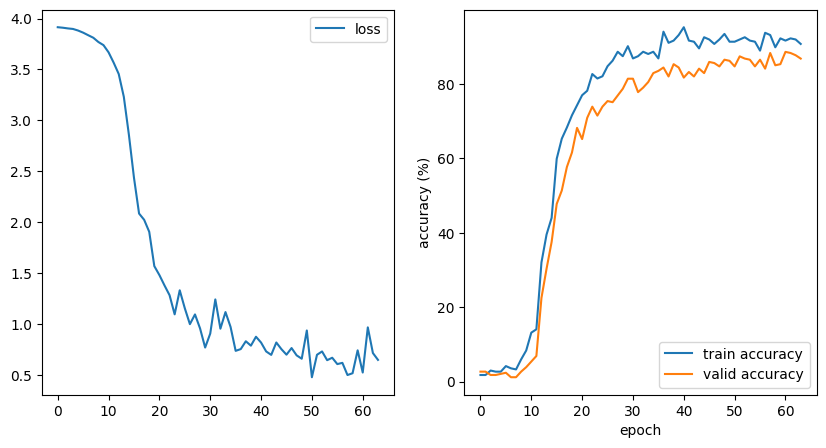

In [9]:
epoch_n = 64

model.train()
model.to(device)

for epoch in range(1, epoch_n + 1):
    loss_sum = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
    
    Y_valid.append(100 * eval_model(model, valid_loader))
    Y_train.append(100 * eval_model(model, train_loader))
    Y_loss.append(loss_sum / len(train_loader))

    print(\
        f'Epoch: {epoch}, \
        loss: {Y_loss[-1]:.3f}, \
        train accuracy: {Y_train[-1]:.1f}%, \
        valid accuracy: {Y_valid[-1]:.1f}%'
    )

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(Y_loss)
plt.legend(['loss'])

plt.subplot(1, 2, 2)
plt.plot(Y_train)
plt.plot(Y_valid)
plt.legend(['train accuracy', 'valid accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy (%)')

plt.show()

In [10]:
print(f'Test accuracy: {eval_model(model, test_loader)}')

Test accuracy: 0.8498498498498499


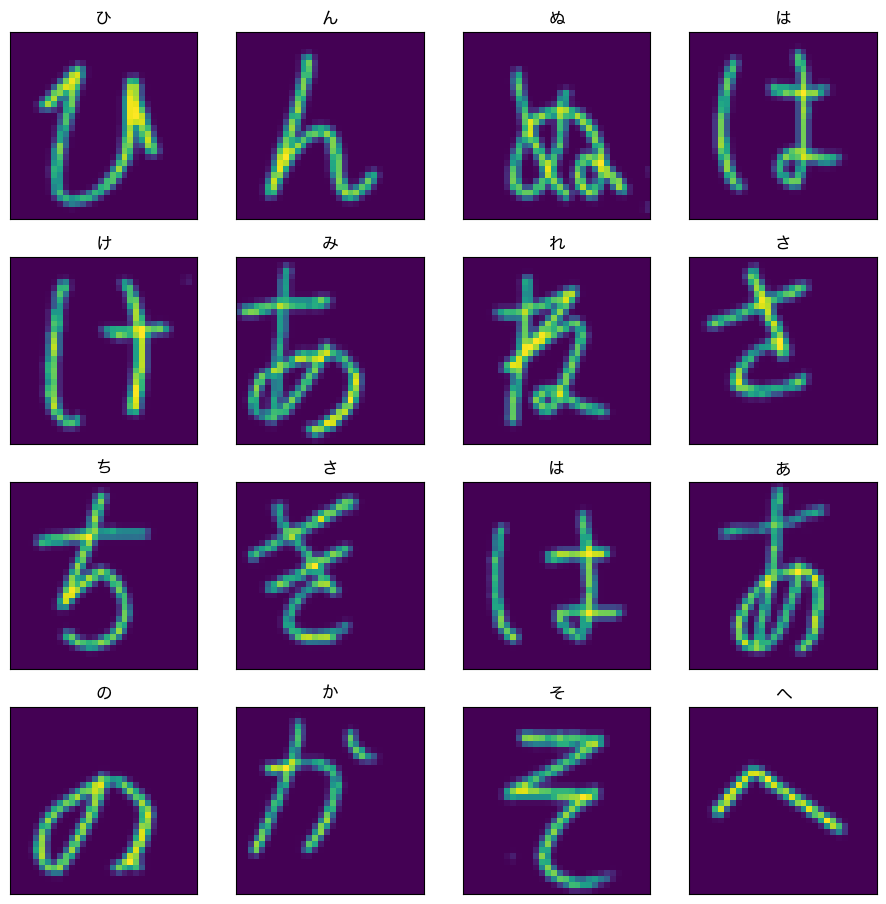

In [14]:
test_dataset = HiraganaDataset(mode='test')
model.to('cpu')
plt.rcParams['font.sans-serif'] = "Microsoft YaHei" 

grid_size = 4
plt.figure(figsize=(0.7 * grid_size**2, 0.7 * grid_size**2))
for i in range(grid_size**2):
    plt.subplot(grid_size, grid_size, i+1)
    id = torch.randint(0, len(test_dataset), (1, )).item()
    plt.imshow(test_dataset[id][0][0])
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

    predicion = model.forward(test_dataset[id][0].unsqueeze(0))
    predicion = torch.argmax(predicion[0])
    predicion = test_dataset.num2lab[predicion.item()]
    predicion = test_dataset.hiragana[predicion.lower()]
    target = test_dataset[id][1]

    plt.title(predicion)

plt.show()
